In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1903e9866c8>,
 'tobs': 65.0,
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'date': '2010-01-01'}

In [11]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1903e98a988>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'longitude': -157.8168,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US'}

In [12]:
session.query(Measurement).count()

19550

In [13]:
session.query(Station).count()

9

In [14]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# step 1: get the last date of the measurement data by listing them in descending order and reading the date on first row.
lastdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#note the result is a list and reading the first index is the date in string format
lastdate[0]

'2017-08-23'

In [16]:
# step 2: convert string to date object format
last_date = dt.datetime.strptime(lastdate[0], '%Y-%m-%d')
last_date

datetime.datetime(2017, 8, 23, 0, 0)

In [92]:
# Calculate the date 1 year ago from the last data point in the database
# step 3: using timedelta function find the query start date (subtract 365 days from the last date of measurement)
query_date = dt.date(last_date.year, last_date.month, last_date.day) - dt.timedelta(days=365)
print("Query Date: ", query_date)
type(query_date)

Query Date:  2016-08-23


datetime.date

In [93]:
# Perform a query to retrieve the data and precipitation scores
# step 4: run the query with query date
result = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df_prcp = pd.DataFrame(result, columns=['Date','Precipitation'])
df_prcp = df_prcp.dropna(how='any') # clean up non value entries
df_prcp = df_prcp.set_index("Date")

# Sort the dataframe by date
df_prcp = df_prcp.sort_values(["Date"], ascending=True)

df_prcp.head(10)

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
2016-08-23,1.79
2016-08-24,1.22
2016-08-24,0.08
2016-08-24,2.15


In [94]:
df_prcp.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


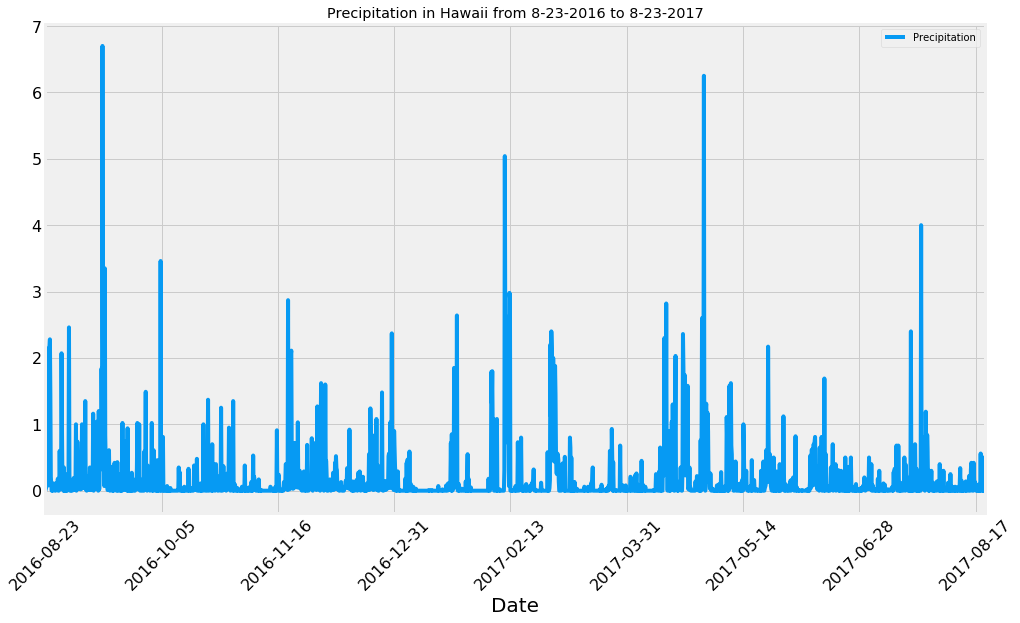

In [95]:
# plot using pandas plot instead of matplotlib
df_prcp.plot(figsize=(15, 9),                                              
               rot=45, 
               use_index=True, 
               title='Precipitation in Hawaii from 8-23-2016 to 8-23-2017', 
               legend=True,
               fontsize=16,
               grid=True,
               color='#069af3' # xkcd azure
              )

plt.xlabel('Date', fontsize=20)
plt.show()

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


![precipitation](Images/precipitation.png)

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data

![describe](Images/describe.png)

In [22]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).count()

9

In [23]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [96]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
observation_count = session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
observation_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [97]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# observation_count result is already organized by most active station as first row.
# Accessing observation_count[0][0] will return the station id.

session.query(Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == observation_count[0][0]).first()

('USC00519281', 54.0, 85.0, 71.66378066378067)

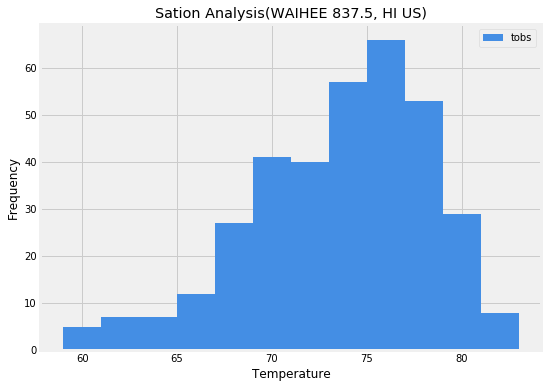

In [107]:
temperature = session.query(Measurement.tobs).\
              filter(Measurement.station == observation_count[0][0]).filter(Measurement.date >= query_date).all()
        
tobs_df = pd.DataFrame(temperature, columns=['tobs'])


fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(tobs_df['tobs'], bins=12, color='#448ee4') 
ax.legend(['tobs'])
ax.set_title('Sation Analysis(WAIHEE 837.5, HI US)')
ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')
plt.show()

In [108]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [109]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [110]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
startdate = '2017-04-01'
enddate = '2017-04-07'
trip_temp = calc_temps(startdate,enddate)[0]
trip_temp

(67.0, 74.58695652173913, 80.0)

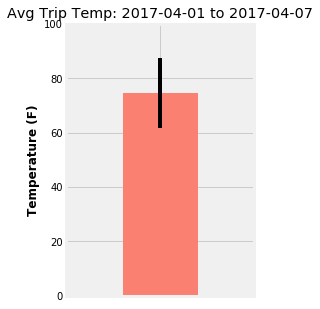

In [111]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,5))                                                    # plots data
plt.xlim(0,2)
plt.ylim(0, 100)
plt.bar(1, trip_temp[1], yerr=(trip_temp[2] - trip_temp[0]), tick_label='', color='salmon')
plt.ylabel("Temperature (F)", weight="bold")
plt.title("Avg Trip Temp: %s to %s" % (startdate, enddate))
plt.show()

In [112]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#convert startdate and enddate to date objects
startdate_obj = dt.datetime.strptime(startdate, '%Y-%m-%d')
enddate_obj = dt.datetime.strptime(enddate, '%Y-%m-%d')

# now determine previous year start date and end date using timedelta
prev_year_start = dt.date(startdate_obj.year, startdate_obj.month, startdate_obj.day) - dt.timedelta(days=365)
prev_year_end = dt.date(enddate_obj.year, enddate_obj.month, enddate_obj.day) - dt.timedelta(days=365)


In [113]:
sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
queryresult = session.query(*sel).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= prev_year_start).\
    filter(Measurement.date <= prev_year_end).\
    order_by(func.sum(Measurement.prcp).desc()).\
    all()
  
rain_by_station = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation','Total Rainfall'])
rain_by_station

,Station,Name,Latitude,Longitude,Elevation,Total Rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.60
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.78
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.44
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.18
4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.04
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.01
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
